# Batch Processing

In this lesson you are going to learn how to train your NN in batches.

> What do you mean batches? 

So far when we have been training our model, we have been feeding it all of our training data on every iteration. Sometimes it may make sense to feed the model small batches of 10 or 100 samples at a time. This will allow our model to update its weights more often and possibly give you better results. In addition you may also end up in a situation that you just do not have enough memory to feed the entire training data. By training in batches, this problem would be solved.

# Let's Get to Work!

In [126]:
# import libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import sys
import datetime
import matplotlib.pyplot as plt
plt.style.use('ggplot') # use this plot style
%matplotlib inline

print('Python version ' + sys.version)
print('Tensorflow version ' + tf.VERSION)
print('Pandas version ' + pd.__version__)
print('Numpy version ' + np.__version__)

Python version 3.6.3 |Anaconda, Inc.| (default, Nov  3 2017, 12:34:11) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Tensorflow version 1.1.0
Pandas version 0.20.3
Numpy version 1.12.1


# Function to model

    y = a * x^4 + b  


> TIP: Recommended percentages  

* Training - ***70%***
* Validation - ***15%***
* Test - ***15%***

In [127]:
# Let's generate 1000 random samples
pool = np.random.rand(1000,1).astype(np.float32)

# Shuffle the samples
np.random.shuffle(pool)

# sample size of 15%
sample = int(1000 * 0.15)

# 15% test
test_x = pool[0:sample]

# 15% validation
valid_x = pool[sample:sample*2]

# 70% training
train_x = pool[sample*2:]

print('Testing data points: ' + str(test_x.shape))
print('Validation data points: ' + str(valid_x.shape))
print('Training data points: ' + str(train_x.shape))

# Let's compute the ouput using 2 for a, 5 for b
test_y = 2.0 * test_x**4 + 5
valid_y = 2.0 * valid_x**4 + 5
train_y = 2.0 * train_x**4 + 5

Testing data points: (150, 1)
Validation data points: (150, 1)
Training data points: (700, 1)


In [128]:
df = pd.DataFrame({'x':train_x[:,0],
                   'y':train_y[:,0]})
df.head()

,x,y
0,0.554851,5.189556
1,0.010345,5.000000
2,0.791529,5.785051
3,0.844018,6.014931
4,0.469589,5.097253


In [129]:
df.describe()

,x,y
count,700.000000,700.000000
mean,0.502394,5.418079
std,0.293510,0.562679
min,0.002778,5.000000
25%,0.242357,5.006900
50%,0.484262,5.109990
75%,0.767710,5.694733
max,0.998325,6.986631


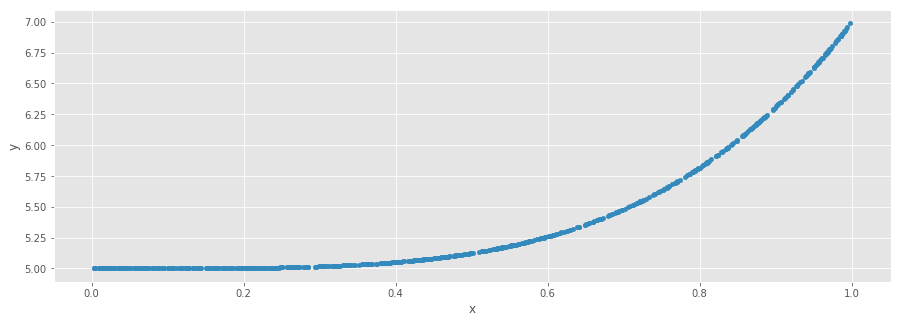

In [130]:
df.plot.scatter(x='x', y='y', figsize=(15,5));

# Helper Functions  

Make a function that will help you create layers easily

In [131]:
def add_layer(inputs, in_size, out_size, activation_function=None):
    
    # tf.random_normal([what is the size of your batches, size of output layer])
    Weights = tf.Variable(tf.truncated_normal([in_size, out_size], mean=0.1, stddev=0.1))
    
    # tf.random_normal([size of output layer])
    biases = tf.Variable(tf.truncated_normal([out_size], mean=0.1, stddev=0.1))
    
    # shape of pred = [size of your batches, size of output layer]
    pred = tf.matmul(inputs, Weights) + biases

    if activation_function is None:
        outputs = pred
    else:
        outputs = activation_function(pred)
    return outputs

# Model your Graph

Start to use W (for weight) and b (for bias) when setting up your variables. Aside from adding your ReLU activation function, it is a good idea to use Tensorflow's ***matrix multiplication function (matmul)*** as shown below.  

> The ? in the shape output just means it can be of any shape.

# Pick Your Batch Size

In [132]:
# larger batch sizes help you get to the local minimum faster at a cost of more cpu power
# The strategy is to use batch_size when you cannot fit the entire dataset into memory
# In practice, small to moderate mini-batches (10-500) are generally used
batch_size = 50

In [133]:
# you can adjust the number of neurons in the hidden layers here
hidden_size = 20

# placeholders
# shape=[how many samples do you have, how many input neurons]
x = tf.placeholder(tf.float32, shape=[None, 1], name="01_x")
y = tf.placeholder(tf.float32, shape=[None, 1], name="01_y")

print("shape of x and y:")
print(x.get_shape(),y.get_shape())

shape of x and y:
(?, 1) (?, 1)


# Add Your Drop Out Placeholder  

We will be feeding in the percentage of neurons to keep on every epoch

In [134]:
# drop out
keep_prob = tf.placeholder(tf.float32)

Note that the input of one layer becomes the input of the next layer.

In [135]:
# create your hidden layers!
h1 = add_layer(x, 1, hidden_size, tf.nn.relu)

# here is where we shoot down some of the neurons
h1_drop = tf.nn.dropout(h1, keep_prob)

# add a second layer
h2 = add_layer(h1_drop, hidden_size, hidden_size, tf.nn.relu)
h2_drop = tf.nn.dropout(h2, keep_prob)

# add a third layer
h3 = add_layer(h2_drop, hidden_size, hidden_size, tf.nn.relu)
h3_drop = tf.nn.dropout(h3, keep_prob)

# add a fourth layer
h4 = add_layer(h3_drop, hidden_size, hidden_size, tf.nn.relu)
h4_drop = tf.nn.dropout(h4, keep_prob)

print("shape of hidden layers:")
print(h1_drop.get_shape(), h2_drop.get_shape(), h3_drop.get_shape(), h4_drop.get_shape())

shape of hidden layers:
(?, 20) (?, 20) (?, 20) (?, 20)


In [136]:
# Output Layers
pred = add_layer(h4_drop, hidden_size, 1)

print("shape of output layer:")
print(pred.get_shape())

shape of output layer:
(?, 1)


In [137]:
# minimize the mean squared errors.
loss = tf.reduce_mean(tf.square(pred - y))

# pick optimizer
optimizer = tf.train.GradientDescentOptimizer(0.0099)
train = optimizer.minimize(loss)

# How Good is Your model?  

Set up the following variables to calculate the accuracy rate of your model. You will do that shortly.

In [138]:
# check accuracy of model
correct_prediction = tf.equal(tf.round(pred), tf.round(y))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Set Up Your Early Stoppage Variables  

Code borrowed from this great [Tensorflow Jupyter Notebook](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/04_Save_Restore.ipynb).

In [139]:
# Best validation accuracy seen so far.
best_valid_acc = 0.0

# Iteration-number for last improvement to validation accuracy.
last_improvement = 0

# Stop optimization if no improvement found in this many iterations.
require_improvement = 1500

# Training Time!  

Variable ***i*** will pull a random sample of n (size of your batches) on every training iteration. Take a look how the variable ***train_data*** was modified.

In [140]:
# Best validation accuracy seen so far.
best_valid_acc = 0.0

# Iteration-number for last improvement to validation accuracy.
last_improvement = 0

# Stop optimization if no improvement found in this many iterations.
require_improvement = 1500

init = tf.global_variables_initializer()

t = []

with tf.Session() as sess:
    
    sess.run(init)
    
    valid_data = {x:valid_x,y:valid_y,keep_prob:1.0}
    test_data = {x:test_x,y:test_y,keep_prob:1.0}
    for step in range(6000):
        
        i = np.random.permutation(train_x.shape[0])[:batch_size]
        
        train_data = {x:train_x[i,:],y:train_y[i,:],keep_prob:0.975}
        
        train_loss,train_pred = sess.run([loss,train],feed_dict=train_data)
        
        if step % 100 == 0:
            
            valid_loss = loss.eval(valid_data)
            
            valid_acc = accuracy.eval(valid_data)
            train_acc = accuracy.eval(train_data)
            
            t.append([step,train_loss,valid_loss])
            
            if valid_acc > best_valid_acc:
                best_valid_acc = valid_acc
                last_improvement = step
                improved_str = '*'
            else:
                improved_str = ''
                
            print("step %d,train_acc:%f,valid_acc:%f,train_loss:%f,valid_loss:%f %s" % (step,train_acc,valid_acc,train_loss,valid_loss,improved_str))            
                
            # If no improvement found in the required number of iterations.
            if step - last_improvement > require_improvement:
                print("No improvement found in a while, stopping optimization.")

                # Break out from the for-loop.
                break    
            
    # here is where you see how good of a Data Scientist you are        
    print("Accuracy on the Training Set:", accuracy.eval(train_data) )
    print("Accuracy on the Validation Set:", accuracy.eval(valid_data) ) 
    print("Accuracy on the Test Set:", accuracy.eval(test_data) )
    # capture predictions on test data 
    test_results = sess.run(pred, feed_dict={x:test_x, keep_prob: 1.0})  
    df_final = pd.DataFrame({'test_x':test_x[:,0],
                             'pred':test_results[:,0]})
    
    # capture training and validation loss
    df_loss = pd.DataFrame(t, columns=['step', 'train_loss', 'valid_loss']) 

step 0,train_acc:0.480000,valid_acc:0.400000,train_loss:0.302422,valid_loss:0.384156 *
step 100,train_acc:0.780000,valid_acc:0.833333,train_loss:0.180482,valid_loss:0.132476 *
step 200,train_acc:0.760000,valid_acc:0.873333,train_loss:0.129863,valid_loss:0.030117 *
step 300,train_acc:0.580000,valid_acc:0.920000,train_loss:0.094908,valid_loss:0.078292 *
step 400,train_acc:0.780000,valid_acc:0.946667,train_loss:0.122491,valid_loss:0.010827 *
step 500,train_acc:0.820000,valid_acc:0.933333,train_loss:0.133287,valid_loss:0.018248 
step 600,train_acc:0.880000,valid_acc:0.953333,train_loss:0.080727,valid_loss:0.008357 *
step 700,train_acc:0.860000,valid_acc:0.986667,train_loss:0.108211,valid_loss:0.007645 *
step 800,train_acc:0.860000,valid_acc:0.986667,train_loss:0.109057,valid_loss:0.004285 
step 900,train_acc:0.840000,valid_acc:0.946667,train_loss:0.079102,valid_loss:0.016613 
step 1000,train_acc:0.880000,valid_acc:0.946667,train_loss:0.096336,valid_loss:0.017250 
step 1100,train_acc:0.9200

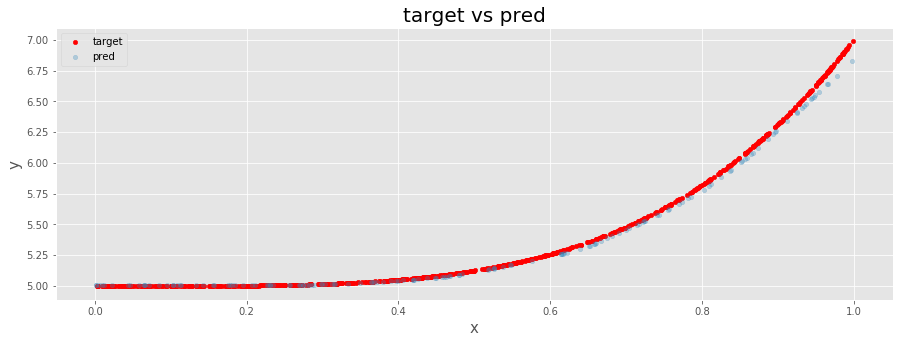

In [141]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

# Chart 1 - Shows the line we are trying to model
df.plot.scatter(x='x', y='y', ax=axes, color='red')

# Chart 2 - Shows the line our trained model came up with
df_final.plot.scatter(x='test_x', y='pred', ax=axes, alpha=0.3)

# add a little sugar
axes.set_title('target vs pred', fontsize=20)
axes.set_ylabel('y', fontsize=15)
axes.set_xlabel('x', fontsize=15)
axes.legend(["target", "pred"], loc='best');

# Check for Overfitting  

If the ***valid_loss*** is increasing and your ***train_loss*** is decreasing then you have a problem. Since you have implemented early stopping, your model will not over train and prevents this issue from getting out of control.

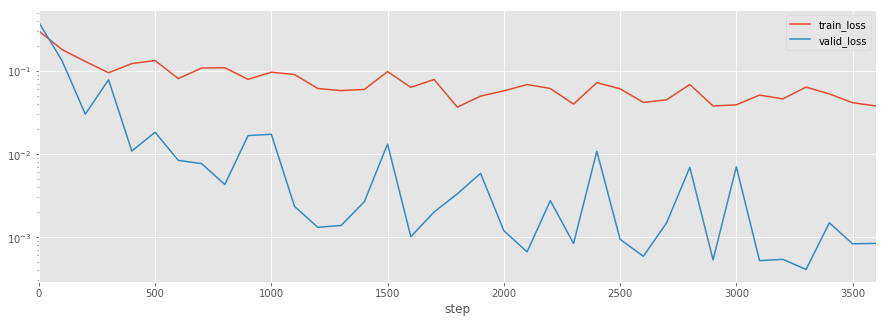

In [142]:
df_loss.set_index('step').plot(logy=True, figsize=(15,5));

# Your Turn  

> Experiment with the batch size and the size of each layer.